In [1]:
#Data and visualisation librarires
import pandas as pd
import seaborn as sns
import numpy as np
import glob

#Data engineering libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler

#Machine learning model libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder
oEnc = OrdinalEncoder()

from sklearn.model_selection import train_test_split

from prophet import Prophet

# To ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading and displaying the required data file
df = pd.DataFrame()
for file_name in glob.glob('DataDemandNPrice'+'/*.csv'):
    x = pd.read_csv(file_name, low_memory=False)
    df = pd.concat([df,x],axis=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214848 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          214848 non-null  object 
 1   SETTLEMENTDATE  214848 non-null  object 
 2   TOTALDEMAND     214848 non-null  float64
 3   RRP             214848 non-null  float64
 4   PERIODTYPE      214848 non-null  object 
dtypes: float64(2), object(3)
memory usage: 9.8+ MB


In [4]:
df.reset_index()

,index,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,0,NSW1,2017/01/01 00:30:00,7259.07,178.36,TRADE
1,1,NSW1,2017/01/01 01:00:00,7046.41,80.21,TRADE
2,2,NSW1,2017/01/01 01:30:00,6845.24,60.85,TRADE
3,3,NSW1,2017/01/01 02:00:00,6629.92,49.42,TRADE
4,4,NSW1,2017/01/01 02:30:00,6472.71,60.51,TRADE
...,...,...,...,...,...,...
214843,8923,NSW1,2022/12/31 23:40:00,6987.28,118.99,TRADE
214844,8924,NSW1,2022/12/31 23:45:00,7038.81,118.99,TRADE
214845,8925,NSW1,2022/12/31 23:50:00,6931.79,106.75,TRADE
214846,8926,NSW1,2022/12/31 23:55:00,6966.57,109.00,TRADE


In [5]:
df.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2017/01/01 00:30:00,7259.07,178.36,TRADE
1,NSW1,2017/01/01 01:00:00,7046.41,80.21,TRADE
2,NSW1,2017/01/01 01:30:00,6845.24,60.85,TRADE
3,NSW1,2017/01/01 02:00:00,6629.92,49.42,TRADE
4,NSW1,2017/01/01 02:30:00,6472.71,60.51,TRADE


In [6]:
df.tail()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
8923,NSW1,2022/12/31 23:40:00,6987.28,118.99,TRADE
8924,NSW1,2022/12/31 23:45:00,7038.81,118.99,TRADE
8925,NSW1,2022/12/31 23:50:00,6931.79,106.75,TRADE
8926,NSW1,2022/12/31 23:55:00,6966.57,109.00,TRADE
8927,NSW1,2023/01/01 00:00:00,6912.65,93.80,TRADE


In [7]:
# submission.to_csv('submission', index= False)

In [8]:
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
# df.set_index('SETTLEMENTDATE', inplace=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214848 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          214848 non-null  object        
 1   SETTLEMENTDATE  214848 non-null  datetime64[ns]
 2   TOTALDEMAND     214848 non-null  float64       
 3   RRP             214848 non-null  float64       
 4   PERIODTYPE      214848 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 9.8+ MB


In [10]:
# data re-sampled based on an hour
df = df.resample('0.5H', on='SETTLEMENTDATE').agg({'TOTALDEMAND':'mean', 'RRP':'mean'})
df = df.reset_index()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  105168 non-null  datetime64[ns]
 1   TOTALDEMAND     105168 non-null  float64       
 2   RRP             105168 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.4 MB


In [12]:
df.head()

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2017-01-01 00:30:00,7259.07,178.36
1,2017-01-01 01:00:00,7046.41,80.21
2,2017-01-01 01:30:00,6845.24,60.85
3,2017-01-01 02:00:00,6629.92,49.42
4,2017-01-01 02:30:00,6472.71,60.51


In [13]:
df.tail()

,SETTLEMENTDATE,TOTALDEMAND,RRP
105163,2022-12-31 22:00:00,7321.591667,109.688333
105164,2022-12-31 22:30:00,7226.963333,113.066667
105165,2022-12-31 23:00:00,7026.251667,99.776667
105166,2022-12-31 23:30:00,6974.888333,110.511667
105167,2023-01-01 00:00:00,6912.650000,93.800000


In [14]:
# train, test = train_test_split(df, train_size = 0.8, random_state = 142)
# print(train.shape)
# print(test.shape)

In [15]:
# # Getting input data and targets for building prediction model

# X_train = train.drop(['TOTALDEMAND','RRP'], axis = 1)
# y_train = train['RRP']

# X_test = test.drop(['TOTALDEMAND','RRP'], axis = 1)
# y_test = test['RRP']

# print("X_train shape: ", X_train.shape)
# print("y_train shape: ", y_train.shape)
# print("\nX_test shape: ", X_test.shape)
# print("y_test shape: ", y_test.shape, "\n")
# print(X_train.head(), "\n")
# print(y_train.head())

In [16]:
df1 = df.drop(['RRP'], axis = 1)
df1.head()

,SETTLEMENTDATE,TOTALDEMAND
0,2017-01-01 00:30:00,7259.07
1,2017-01-01 01:00:00,7046.41
2,2017-01-01 01:30:00,6845.24
3,2017-01-01 02:00:00,6629.92
4,2017-01-01 02:30:00,6472.71


In [17]:
df1 = df1.rename(columns={'SETTLEMENTDATE': 'ds', 'TOTALDEMAND': 'y'})
df1.head()

,ds,y
0,2017-01-01 00:30:00,7259.07
1,2017-01-01 01:00:00,7046.41
2,2017-01-01 01:30:00,6845.24
3,2017-01-01 02:00:00,6629.92
4,2017-01-01 02:30:00,6472.71


In [18]:
model = Prophet()
model.fit(df1)

22:12:04 - cmdstanpy - INFO - Chain [1] start processing
22:13:14 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future = model.make_future_dataframe(periods=1095)
future.tail()

,ds
106258,2025-12-27
106259,2025-12-28
106260,2025-12-29
106261,2025-12-30
106262,2025-12-31


In [20]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
106258,2025-12-27,6167.246612,-21443.920567,33563.835234
106259,2025-12-28,5574.098024,-22029.234824,32908.284720
106260,2025-12-29,5932.103690,-21421.749407,33418.755126
106261,2025-12-30,6463.362074,-21736.011090,33742.580051
106262,2025-12-31,6389.532556,-21593.658469,33654.506422


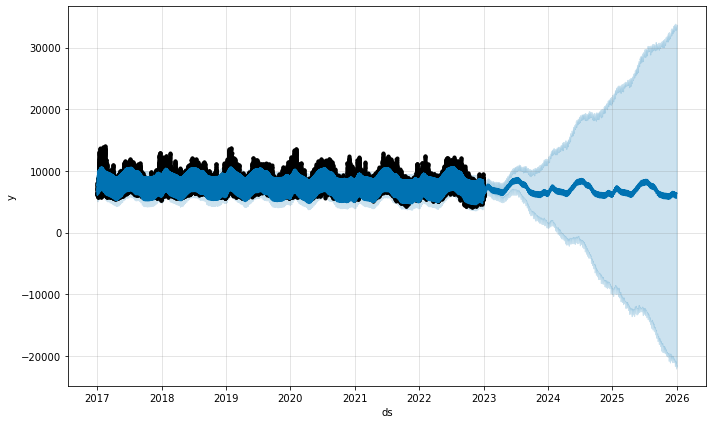

In [21]:
fig1 = model.plot(forecast)

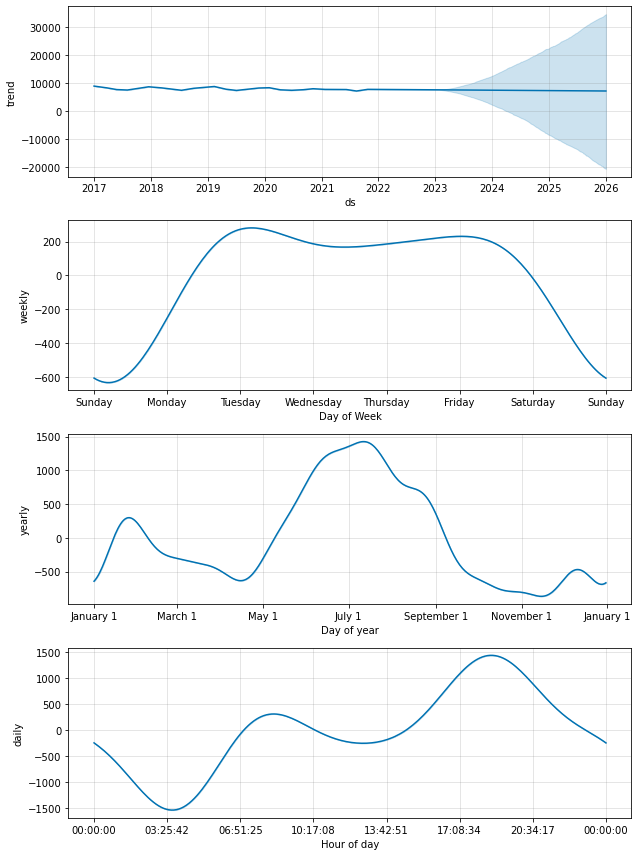

In [22]:
fig2 = model.plot_components(forecast)

In [23]:
df2 = df.drop(['TOTALDEMAND'], axis = 1)
df2.head()

,SETTLEMENTDATE,RRP
0,2017-01-01 00:30:00,178.36
1,2017-01-01 01:00:00,80.21
2,2017-01-01 01:30:00,60.85
3,2017-01-01 02:00:00,49.42
4,2017-01-01 02:30:00,60.51


In [24]:
df2 = df2.rename(columns={'SETTLEMENTDATE': 'ds', 'RRP': 'y'})
df2.head()

,ds,y
0,2017-01-01 00:30:00,178.36
1,2017-01-01 01:00:00,80.21
2,2017-01-01 01:30:00,60.85
3,2017-01-01 02:00:00,49.42
4,2017-01-01 02:30:00,60.51


In [25]:
m = Prophet()
m.fit(df2)

22:14:12 - cmdstanpy - INFO - Chain [1] start processing
22:14:46 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future1 = m.make_future_dataframe(periods=365)
future1.tail()

,ds
105528,2023-12-28
105529,2023-12-29
105530,2023-12-30
105531,2023-12-31
105532,2024-01-01


In [27]:
forecast1 = m.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
106258,2025-12-27,252.752848,-6200.661712,6921.135538
106259,2025-12-28,232.206126,-6167.003744,6899.956243
106260,2025-12-29,239.948483,-6099.893008,6968.437246
106261,2025-12-30,256.634078,-6077.789532,6928.466611
106262,2025-12-31,252.044973,-6187.783254,6900.831365


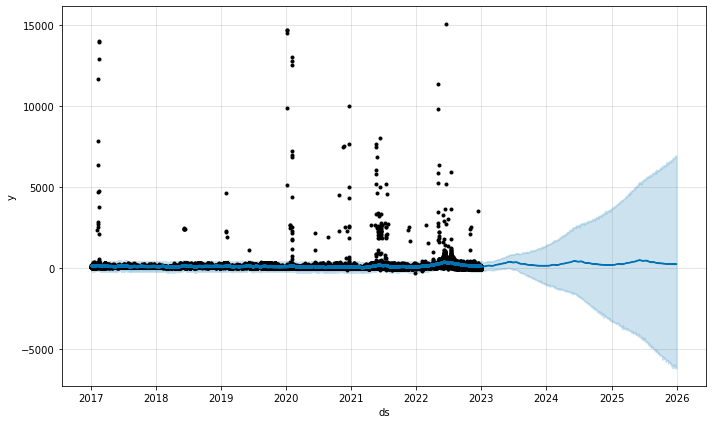

In [28]:
fig3 = m.plot(forecast1)

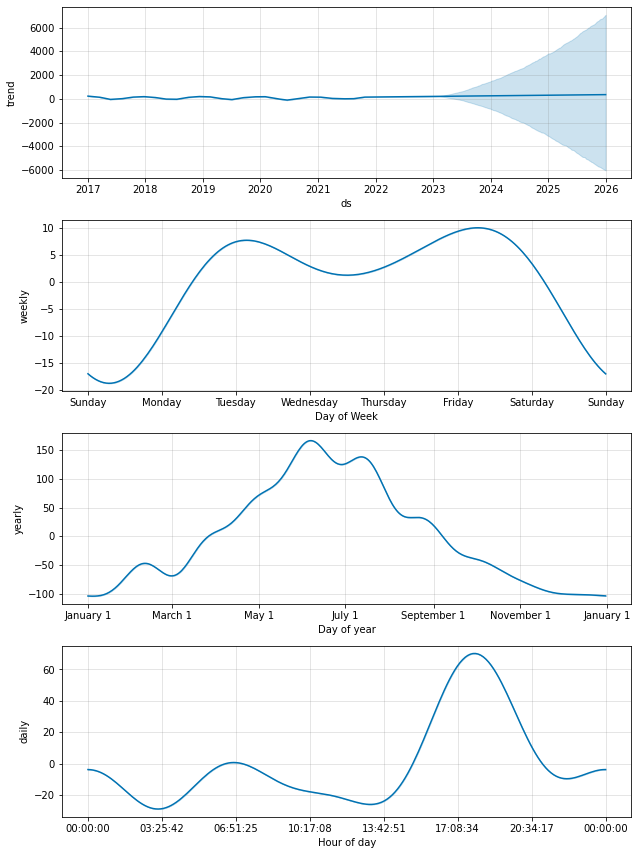

In [29]:
fig4 = m.plot_components(forecast1)

In [31]:
forecast.to_csv('3years')